In [1]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#import dataset
df = pd.read_csv ('WinnipegDataset.txt',sep = ",")

## Exploratory Data Analysis

The display of the attributes and their data types was not run because when the output pdf is created the 175 columns when plotted in the pdf take up a lot of redundant space.

In [ ]:
# determine data types in dataset
df.dtypes

In [ ]:
#display attributes
display(df)

In [2]:
# identifies columns having null values as a list
df.columns[df.isna().any()].tolist()

[]

(array([39162.,  3598., 75673., 74067., 47117., 85074.,  1143.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <BarContainer object of 7 artists>)

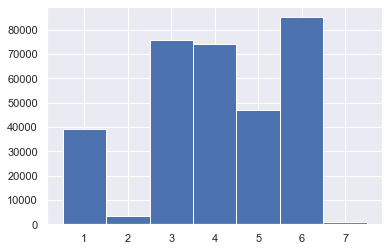

In [3]:
# plot histogram of label column
plt.hist(df['label'], bins=np.arange(df['label'].min(), df['label'].max()+2)-0.5)

The histograms, boxplots and descriptive stats of the attributes were not run because when the output pdf is created the 175 columns when plotted in the pdf take up a lot of redundant space.

In [ ]:
# histograms of dataset attributes
for column in df:
    plt.figure()
    df.hist([column])

In [ ]:
# boxplots of dataset attributes
for column in df:
    plt.figure()
    df.boxplot([column])

In [ ]:
# descriptive statistics of attributes
print(df.describe(include='all'))

It was decided not to drop any features or remove any outliers. Outliers were not removed because in remote sensing each value of attribute corresponds to a pixel in the output remote sensing image. In essesnce by removing that value you would not be able to classify that pixel.

## Split Dataset

In [4]:
# prepare data for train/test split
X = df.drop("label", 1)
y = df['label']

In [5]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
# standardize the X dataset
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Reduce Dimensions Using Principal Component Analysis

In [7]:
# run base PCA using all components
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Text(0, 0.5, 'cumulative explained variance')

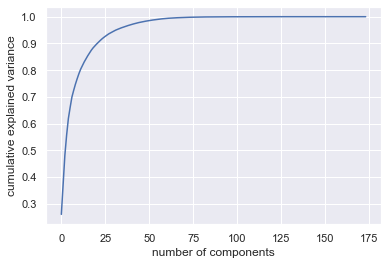

In [8]:
# plot variance explained by number of components in PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [9]:
# 11 components were determined to give the highest accuracy when running base RandomForestClassifier
pca = PCA(n_components = 11)
X_train_pca11 = pca.fit_transform(X_train)
X_test_pca11 = pca.transform(X_test)

## Fine Tune Hyperparameters of Random Forest Classifier

In [10]:
# next sections uses random grid and search to fine tune hyperparameters of RandomForest classifier

n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [11]:
# create RandomForest classifier
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()

In [ ]:
# create RandomizedSearch object with parameters
from sklearn.model_selection import RandomizedSearchCV
classifier_random = RandomizedSearchCV(estimator = classifier,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
# run the RandomizedSearch classifier on training data to determine best parameters for RandomForest classifier run
classifier_random.fit(X_train_pca11, y_train)

In [ ]:
# print random grid parameters
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', classifier_random.best_params_, ' \n')

## Random Forest Classifier Model

In [12]:
# run the RandomForest classifier using fine tuned settings
from sklearn.ensemble import RandomForestClassifier

classifier_finetune = RandomForestClassifier(n_estimators=50, min_samples_split=6, min_samples_leaf=1, max_features='sqrt', max_depth=100, bootstrap=False, random_state=0)
classifier_finetune.fit(X_train_pca11, y_train)

# Predicting the Test set results
y_pred = classifier_finetune.predict(X_test_pca11)

In [13]:
# create confusion matrix and calculate accuracy and cohen's kappa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

cm = confusion_matrix(y_test, y_pred)
print(cm, ' \n')
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))

[[11793     4     8    36     2     5     8]
 [    3  1065     0     2     0     0     0]
 [    1     2 22787    25     4    15     0]
 [   36     0    26 22215    30    29     0]
 [   20     1     9    59 13499   379     6]
 [   17     0    10    33   170 25103     4]
 [   16     2     0     0     1     3   323]]  

              precision    recall  f1-score   support

           1       0.99      0.99      0.99     11856
           2       0.99      1.00      0.99      1070
           3       1.00      1.00      1.00     22834
           4       0.99      0.99      0.99     22336
           5       0.98      0.97      0.98     13973
           6       0.98      0.99      0.99     25337
           7       0.95      0.94      0.94       345

    accuracy                           0.99     97751
   macro avg       0.98      0.98      0.98     97751
weighted avg       0.99      0.99      0.99     97751

Accuracy: 0.990117748156029
Cohen's Kappa: 0.9874987087036211
